In [2]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import krippendorff
import numpy as np

# BirdWatch Data Analysis

Data Day: 18th September 2021 05:02 PM (Paris Time)

Hydration Day: 25th September  2021 09:26 AM (Paris Time)

In [4]:
notes_file = '../data/notes-00000.tsv'
ratings_file = '../data/ratings-00000.tsv'
hydrated_file = '../data/idtweetVALUES.jsonl'

In [5]:
notes_df = pd.read_csv(notes_file, delimiter='\t')

In [6]:
notes_df.iloc[3]

noteId                                                                  1356735932087611399
participantId                                              7EDD07641861C52611BCEB9F9BE7CD21
createdAtMillis                                                               1612306027803
tweetId                                                                 1352754599590035459
classification                                        MISINFORMED_OR_POTENTIALLY_MISLEADING
believable                                                               BELIEVABLE_BY_MANY
harmful                                                                   CONSIDERABLE_HARM
validationDifficulty                                                                   EASY
misleadingOther                                                                           0
misleadingFactualError                                                                    1
misleadingManipulatedMedia                                                      

* __Notes Column Explanations__:
    * __noteId__: Unique ID of the note
    * __participantId__: ID of the participant (remains stable even if the user changes their username/handle)
    * __createdAtMillis__: Time the note was created, in milliseconds since epoch
    * __tweetId__: The tweetId number for the tweet that the note is about
    * __classification__: User-entered multiple choice response to note writing question: “Given current evidence, I believe this tweet is:” “NOT_MISLEADING” or “MISINFORMED_OR_POTENTIALLY_MISLEADING”
    * __believable__: User-entered multiple choice response to note writing question: “If this tweet were widely spread, its message would likely be believed by:” “BELIEVABLE_BY_FEW”, “BELIEVABLE_BY_MANY”
    * __harmful__: User-entered multiple choice response to note writing question: “If many believed this tweet, it might cause:”, “LITTLE_HARM”, “CONSIDERABLE_HARM”
    * __validationDifficulty__: User-entered multiple choice response to note writing question: “Finding and understanding the correct information would be:”,“EASY”, “CHALLENGING”
    * __misleading(SOMETHING)__:  User-entered checkbox in response to question “Why do you believe this tweet may be misleading?” (Check all that apply question type)., True if SOMETHING else FALSE
    * __notMisleading(SOMETHING)__:  User-entered checkbox in response to question “Why do you believe this tweet is not misleading?” (Check all that apply question type)., True if SOMETHING else FALSE
    * __trustworthySources__: Binary indicator, based on user-entered multiple choice in response to note writing question “Did you link to sources you believe most people would consider trustworthy?”, 1 if “Yes” is selected, 0 if “No” is selected
    * __summary__: User-entered text, in response to the note writing prompt “Please explain the evidence behind your choices, to help others who see this tweet understand why it is not misleading”,User entered text explanation, with some characters escaped (e.g. tabs converted to spaces).


In [7]:
ratings_df = pd.read_csv(ratings_file, delimiter='\t')

In [8]:
ratings_df.iloc[3]

noteId                                                1352796878438424576
participantId                            628C786C63B5A4D32E13C6C442E1863D
createdAtMillis                                             1611623203338
version                                                                 1
agree                                                                   0
disagree                                                                0
helpful                                                                 0
notHelpful                                                              1
helpfulnessLevel                                                      NaN
helpfulOther                                                            0
helpfulInformative                                                      0
helpfulClear                                                            0
helpfulEmpathetic                                                       0
helpfulGoodSources                    

* __Ratings Columns Explanations__:
    * __noteId__: The unique ID of the note being rated.
    * __participantId__: A Birdwatch-specific user identifier of the user who authored the rating. This is a permanent id, which remains stable even if the user changes their username/handle.
    * __createdAtMillis__: Time the note was created, in milliseconds since epoch.
    * __agree__: Binary indicator, based on user-entered multiple choice in response to note rating question “Do you agree with its conclusion?”, 1 if “Yes” is selected, 0 if “No” is selected
    * __disagree__: Binary indicator, based on user-entered multiple choice in response to note rating question “Do you agree with its conclusion?”, 1 if “No” is selected, 0 if “Yes” is selected
    * __helpful__: Deprecated
    * __notHelpful__: Deprecated
    * __helpfulnessLevel__: User-entered multiple choice response to note rating question: “Is this note helpful” Added as of 2021-06-30.,“NOT_HELPFUL” “SOMEWHAT_HELPFUL” “HELPFUL”
    * __helpful(SOMETHING)__: User-entered checkbox in response to question “What about this note was helpful to you?” (Check all that apply question type)., 1 if SOMETHING is selected, else 0.
     * __helpfulInformative__: Deprecated
     * __helpfulEmpathetic__: Deprecated
     * __helpfulUniqueContext__: Deprecated
     * __notHelpful(SOMETHING)__: User-entered checkbox in response to prompt “Help us understand why this note was unhelpful” (Check all that apply question type)., 1 if SOMETHING is selected, else 0.
     * __NotHelpfulOpinionSpeculationOrBias__: Deprecated
     * __notHelpfulOutdated__: Deprecated
     * __notHelpfulOffTopic__: Deprecated
     
Checked added columns <a href = "https://twitter.github.io/birdwatch/contributing/download-data/">here</a>.

In [9]:
deprecated_cols= ['helpful',
                  'notHelpful',
                  'helpfulInformative',
                  'helpfulEmpathetic',
                  'helpfulUniqueContext',
                  'notHelpfulOpinionSpeculationOrBias',
                  'notHelpfulOutdated',
                  'notHelpfulOffTopic']

In [10]:
ratings_df = ratings_df.drop(deprecated_cols,axis=1)

In [11]:
hydrated_Tweets=pd.read_json(hydrated_file, lines=True)

__Hydrated Columns Explanations__ can be found <a href="https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet">here</a>.
     

In [12]:
notes_text_df = pd.merge(notes_df, hydrated_Tweets, left_on='tweetId', right_on='id')

In [13]:
notes_text_ratings = pd.merge(notes_text_df,ratings_df,on='noteId')

In [14]:
ratings_df.drop_duplicates().shape

(86924, 20)

In [15]:
notes_ratings=pd.merge(notes_df,ratings_df,on='noteId')

In [16]:
len(set(notes_df.noteId))

15445

In [17]:
len(set(notes_df.tweetId))

11871

In [18]:
len(set(notes_text_df.noteId))

13356

In [19]:
len(set(notes_text_ratings.noteId))

8786

In [20]:
data=(notes_df.groupby('tweetId') \
        .agg({'noteId':'count'}) \
        .reset_index()['noteId']).value_counts()
data=pd.DataFrame(data)
data.columns=['Count']
data['NumNotes']=data.index

In [21]:
index=['1','2','3','4','5','>5']
data2 = pd.DataFrame(0,index=index,columns=['Count'])
for ind in index:
    if ind =='>5':
        data2.loc[ind]=data[data['NumNotes']>5]['Count'].sum()
    else:
        data2.loc[ind]=data.loc[int(ind)]['Count']

data2['NumNotes']=data2.index

In [22]:
data2

,Count,NumNotes
1,9841,1
2,1312,2
3,409,3
4,160,4
5,62,5
>5,87,>5


In [94]:
data2.to_csv('Notes.csv',index=False)

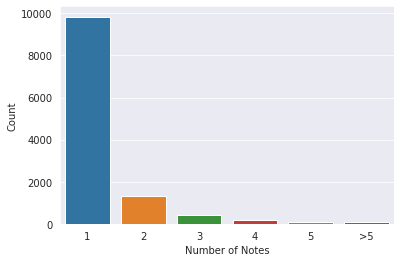

In [23]:
sns.set_style('darkgrid')
sns.barplot(data=data2,x='NumNotes',y='Count')
plt.xlabel('Number of Notes')
plt.savefig('NotesHist.png')
plt.show()

Text(0.5, 1.0, 'Density Plot of Note Counts')

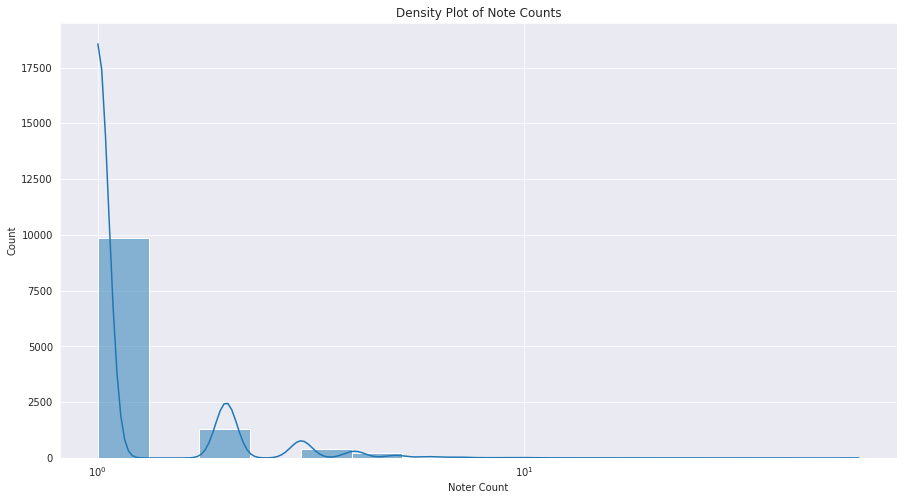

In [24]:
#number of notes per tweet
plt.figure(figsize=(15,8))
#plt.xlim(1,61)
sns.histplot(notes_df.groupby('tweetId') \
        .agg({'noteId':'count'}) \
        .reset_index()['noteId'],
         kde=True,kde_kws={'bw_adjust':1},log_scale=True)
plt.xlabel('Noter Count')
plt.title('Density Plot of Note Counts')

In [25]:
data=(notes_ratings.groupby('noteId') \
        .agg({'participantId_y':'count'}) \
        .reset_index()['participantId_y']).value_counts()

In [26]:
s=notes_ratings.groupby('noteId') \
        .agg({'participantId_y':'count'}) \
        .reset_index()

In [27]:
s[s.participantId_y==max(s.participantId_y)]

,noteId,participantId_y
9498,1436362984750714886,184


In [28]:
data.sort_index()

1      1551
2      1562
3      1252
4       998
5       686
       ... 
144       1
145       1
148       3
149       2
184       1
Name: participantId_y, Length: 127, dtype: int64

In [29]:
data=pd.DataFrame(data)

In [30]:
data.columns=['Count']

In [31]:
data['RatingCount']=data.index

In [32]:
sorted(dict(zip(data['RatingCount'],data['Count'])).items(),key=lambda x: x[0])

[(1, 1551),
 (2, 1562),
 (3, 1252),
 (4, 998),
 (5, 686),
 (6, 566),
 (7, 428),
 (8, 400),
 (9, 256),
 (10, 233),
 (11, 201),
 (12, 163),
 (13, 144),
 (14, 122),
 (15, 114),
 (16, 108),
 (17, 104),
 (18, 50),
 (19, 62),
 (20, 64),
 (21, 62),
 (22, 52),
 (23, 52),
 (24, 40),
 (25, 42),
 (26, 30),
 (27, 31),
 (28, 30),
 (29, 20),
 (30, 31),
 (31, 22),
 (32, 23),
 (33, 30),
 (34, 25),
 (35, 17),
 (36, 16),
 (37, 23),
 (38, 13),
 (39, 19),
 (40, 16),
 (41, 13),
 (42, 7),
 (43, 14),
 (44, 14),
 (45, 13),
 (46, 15),
 (47, 14),
 (48, 7),
 (49, 8),
 (50, 11),
 (51, 7),
 (52, 4),
 (53, 11),
 (54, 3),
 (55, 11),
 (56, 5),
 (57, 7),
 (58, 4),
 (59, 6),
 (60, 4),
 (61, 5),
 (62, 1),
 (63, 3),
 (64, 7),
 (65, 6),
 (66, 5),
 (67, 3),
 (68, 10),
 (69, 5),
 (70, 2),
 (71, 4),
 (72, 1),
 (73, 5),
 (74, 4),
 (75, 1),
 (76, 7),
 (77, 2),
 (78, 2),
 (79, 7),
 (80, 3),
 (81, 3),
 (82, 2),
 (83, 3),
 (84, 3),
 (85, 3),
 (86, 2),
 (87, 2),
 (89, 2),
 (90, 2),
 (91, 1),
 (92, 4),
 (93, 4),
 (94, 3),
 (95, 2),

In [33]:
sup=15
index=[str(x) for x in range(1,sup+1)]+[f'>{sup}']

data2 = pd.DataFrame(0,index=index,columns=['Count'])
for ind in index:
    if ind ==f'>{sup}':
        data2.loc[ind]=data[data['RatingCount']>sup]['Count'].sum()
    else:
        data2.loc[ind]=data.loc[int(ind)]['Count']

data2['NumRating']=data2.index

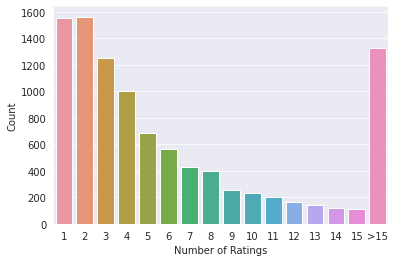

In [34]:
sns.set_style('darkgrid')
sns.barplot(data=data2,x='NumRating',y='Count')
plt.xlabel('Number of Ratings')
plt.savefig('RatingsHist.png')
plt.show()

Text(0.5, 1.0, 'Density Plot of Rater Counts')

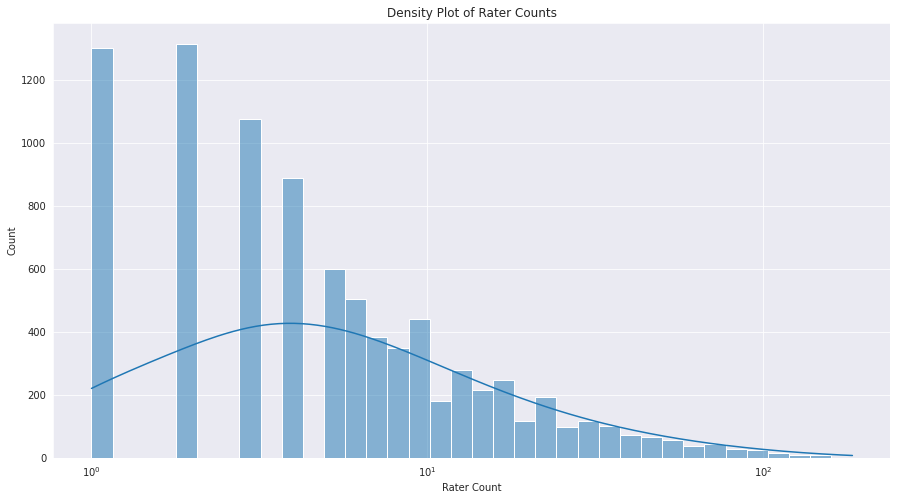

In [35]:
#number of users per note
plt.figure(figsize=(15,8))
sns.histplot(notes_text_ratings.groupby('noteId') \
        .agg({'participantId_y':'count'}) \
        .reset_index()['participantId_y'],
         kde=True,kde_kws={'bw_adjust':3},log_scale=True)
plt.xlabel('Rater Count')
plt.title('Density Plot of Rater Counts')

Text(0.5, 1.0, 'Density Plot of Noter+Rater Counts')

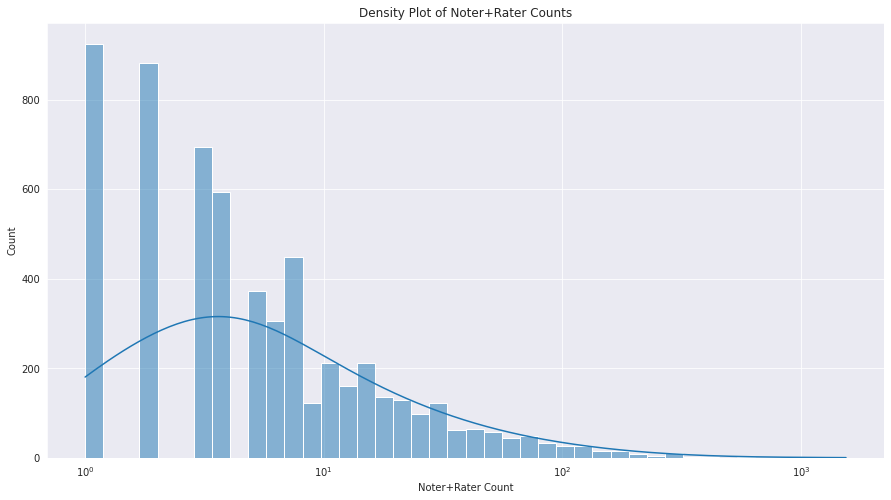

In [36]:
#number of raters+noters per tweet
plt.figure(figsize=(15,8))
sns.histplot(notes_text_ratings.groupby('tweetId') \
        .agg({'participantId_y':'count'}) \
        .reset_index()['participantId_y'],
         kde=True,kde_kws={'bw_adjust':3},log_scale=True)
plt.xlabel('Noter+Rater Count')
plt.title('Density Plot of Noter+Rater Counts')

# Inter-Annotator Agreement

## Krippendorff's alpha


In [37]:
cat_columns = ['classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources']

In [38]:
pids = list(set(notes_df.participantId))

tids = list(set(notes_df.tweetId))

m=pd.DataFrame(np.nan,index=pids,columns=tids)

col='misleadingManipulatedMedia'
label2code = dict(zip(notes_df[col],pd.factorize(notes_df[col])[0]))

for index,row in tqdm(notes_df.iterrows()):
    p=row.participantId
    t=row.tweetId
    m.loc[p,t]=label2code[row[col]]

15445it [00:03, 4648.30it/s]


In [39]:
print(f"Krippendorff's alpha for {col}: ", krippendorff.alpha(reliability_data=m.to_numpy().tolist(),
                                                                          level_of_measurement='nominal'))

Krippendorff's alpha for misleadingManipulatedMedia:  0.45644270861954117


In [41]:
agg_notes_df = notes_df.groupby('tweetId')\
                       .agg({'noteId':'count'})

TweetsWithMoreThanTwoNoters = list(agg_notes_df[agg_notes_df['noteId']>1].index)
print(len(TweetsWithMoreThanTwoNoters)/len(notes_df)*100)
ParticipantsForTweetsWithMoreThanTwoNoters = list(set(notes_df[notes_df.apply(lambda x: True if x.tweetId in TweetsWithMoreThanTwoNoters else False,axis =1)].participantId))


tweet_noter_df = pd.DataFrame(np.nan, index=ParticipantsForTweetsWithMoreThanTwoNoters,columns=TweetsWithMoreThanTwoNoters)
notes_df_more_than_two_notes = notes_df[notes_df.apply(lambda x: True if x.tweetId in TweetsWithMoreThanTwoNoters else False,axis=1)]

categorical_column = 'classification'
for categorical_column in cat_columns: #[categorical_column]:#cat_columns:
    label2code = dict(zip(notes_df[categorical_column],pd.factorize(notes_df[categorical_column])[0]))
    tweet_noter_df_copy = tweet_noter_df.copy()

    for index,row in notes_df_more_than_two_notes.iterrows():
        participantId = row.participantId
        tweetId       = row.tweetId
        tweet_noter_df_copy.loc[participantId,tweetId] = label2code[row[categorical_column]]
    tweet_noter_matrix = tweet_noter_df_copy.to_numpy().tolist()

    print(f"Krippendorff's alpha for {categorical_column}: ", krippendorff.alpha(reliability_data=tweet_noter_matrix,
                                                                          level_of_measurement='nominal'))

13.143412107478147
Krippendorff's alpha for classification:  0.08008452670782029
Krippendorff's alpha for believable:  0.09251373580652988
Krippendorff's alpha for harmful:  0.1432956429860015
Krippendorff's alpha for validationDifficulty:  0.05435032227807268
Krippendorff's alpha for misleadingOther:  0.046752607460758155
Krippendorff's alpha for misleadingFactualError:  0.17750858152594717
Krippendorff's alpha for misleadingManipulatedMedia:  0.4564427086195413
Krippendorff's alpha for misleadingOutdatedInformation:  0.11083501404620455
Krippendorff's alpha for misleadingMissingImportantContext:  0.1368541045253192
Krippendorff's alpha for misleadingUnverifiedClaimAsFact:  0.16766910322822137
Krippendorff's alpha for misleadingSatire:  0.27499581392810557
Krippendorff's alpha for notMisleadingOther:  0.0022371037060846533
Krippendorff's alpha for notMisleadingFactuallyCorrect:  0.09341699972472806
Krippendorff's alpha for notMisleadingOutdatedButNotWhenWritten:  0.09774072081764396
K

In [42]:
agg_notes_df = notes_df.groupby('tweetId')\
                       .agg({'noteId':'count'})

TweetsWithMoreThanTwoNoters = list(agg_notes_df[agg_notes_df['noteId']>0].index)
print(len(TweetsWithMoreThanTwoNoters)/len(notes_df)*100)
ParticipantsForTweetsWithMoreThanTwoNoters = list(set(notes_df[notes_df.apply(lambda x: True if x.tweetId in TweetsWithMoreThanTwoNoters else False,axis =1)].participantId))


tweet_noter_df = pd.DataFrame(np.nan, index=ParticipantsForTweetsWithMoreThanTwoNoters,columns=TweetsWithMoreThanTwoNoters)
notes_df_more_than_two_notes = notes_df[notes_df.apply(lambda x: True if x.tweetId in TweetsWithMoreThanTwoNoters else False,axis=1)]

categorical_column = 'classification'
for categorical_column in cat_columns:
    label2code = dict(zip(notes_df[categorical_column],pd.factorize(notes_df[categorical_column])[0]))
    tweet_noter_df_copy = tweet_noter_df.copy()

    for index,row in notes_df_more_than_two_notes.iterrows():
        participantId = row.participantId
        tweetId       = row.tweetId
        tweet_noter_df_copy.loc[row.participantId,row.tweetId] = label2code[row[categorical_column]]
    tweet_noter_matrix = tweet_noter_df_copy.to_numpy().tolist()

    print(f"Krippendorff's alpha for {categorical_column}: ", krippendorff.alpha(reliability_data=tweet_noter_matrix,
                                                                          level_of_measurement='nominal'))

76.85982518614438
Krippendorff's alpha for classification:  0.08008452670782029
Krippendorff's alpha for believable:  0.09251373580652988
Krippendorff's alpha for harmful:  0.1432956429860015
Krippendorff's alpha for validationDifficulty:  0.05435032227807268
Krippendorff's alpha for misleadingOther:  0.046752607460758155
Krippendorff's alpha for misleadingFactualError:  0.17750858152594717
Krippendorff's alpha for misleadingManipulatedMedia:  0.4564427086195413
Krippendorff's alpha for misleadingOutdatedInformation:  0.11083501404620455
Krippendorff's alpha for misleadingMissingImportantContext:  0.1368541045253192
Krippendorff's alpha for misleadingUnverifiedClaimAsFact:  0.16766910322822137
Krippendorff's alpha for misleadingSatire:  0.27499581392810557
Krippendorff's alpha for notMisleadingOther:  0.0022371037060846533
Krippendorff's alpha for notMisleadingFactuallyCorrect:  0.09341699972472806
Krippendorff's alpha for notMisleadingOutdatedButNotWhenWritten:  0.09774072081764396
Kr

In [51]:
def GetColumnAlpha(original_df, categorical_column, matrix_row, matrix_col):
    
    agg_notes_df = original_df.groupby(matrix_row)\
                           .agg({matric_col:'count'})

    TweetsWithMoreThanTwoNoters = list(agg_notes_df[agg_notes_df[matric_col]>1].index)
    ParticipantsForTweetsWithMoreThanTwoNoters = list(set(original_df[original_df.apply(lambda x: True if x[matrix_row] in TweetsWithMoreThanTwoNoters else False,axis =1)].participantId))

    tweet_noter_df = pd.DataFrame(np.nan, index=ParticipantsForTweetsWithMoreThanTwoNoters,columns=TweetsWithMoreThanTwoNoters)
    notes_df_more_than_two_notes = original_df[original_df.apply(lambda x: True if x[matrix_row] in TweetsWithMoreThanTwoNoters else False,axis=1)]

    label2code = dict(zip(original_df[categorical_column],pd.factorize(original_df[categorical_column])[0]))
    for index,row in tqdm(notes_df_more_than_two_notes.iterrows()):
        participantId = row.participantId
        tweetId       = row[matrix_row]
        tweet_noter_df.loc[row.participantId,row[matrix_row]] = label2code[row[categorical_column]]

    tweet_noter_matrix = tweet_noter_df.to_numpy().tolist()
    alpha = krippendorff.alpha(reliability_data=tweet_noter_matrix, level_of_measurement='nominal')
    return alpha

In [52]:
matrix_row = 'tweetId'
matric_col = 'noteId'
categorical_column = 'misleadingFactualError'

GetColumnAlpha(notes_df, categorical_column, matrix_row, matric_col)

5604it [00:01, 3940.05it/s]


0.17750858152594717

In [55]:
cat_columns = ['agree',
       'disagree', 'helpfulnessLevel', 'helpfulOther', 'helpfulClear',
       'helpfulGoodSources', 'helpfulAddressesClaim',
       'helpfulImportantContext', 'notHelpfulOther', 'notHelpfulIncorrect',
       'notHelpfulSourcesMissingOrUnreliable', 'notHelpfulMissingKeyPoints',
       'notHelpfulHardToUnderstand', 'notHelpfulArgumentativeOrInflammatory',
       'notHelpfulSpamHarassmentOrAbuse', 'notHelpfulIrrelevantSources']

agg_rates_df = ratings_df.groupby('noteId')\
                         .agg({'participantId':'count'})

NotesWithMoreThanTwoRaters = list(agg_rates_df[agg_rates_df['participantId']>1].index)

print(len(NotesWithMoreThanTwoRaters)/len(ratings_df)*100)

ParticipantsForNotesWithMoreThanTwoRaters = list(set(ratings_df[ratings_df.apply(lambda x: True if x.noteId in NotesWithMoreThanTwoRaters else False,axis =1)].participantId))

note_rater_df = pd.DataFrame(np.nan, index=ParticipantsForNotesWithMoreThanTwoRaters,columns=NotesWithMoreThanTwoRaters)

rating_df_more_than_two_raters = ratings_df[ratings_df.apply(lambda x: True if x.noteId in NotesWithMoreThanTwoRaters else False,axis=1)]


categorical_column = 'agree'
for categorical_column in cat_columns:
    label2code = dict(zip(ratings_df[categorical_column],pd.factorize(ratings_df[categorical_column])[0]))
    note_rater_df_copy = note_rater_df.copy()
    for index,row in rating_df_more_than_two_raters.iterrows():
        participantId = row.participantId
        noteId       = row.noteId
        note_rater_df_copy.loc[row.participantId,row.noteId] = label2code[row[categorical_column]]

    note_rater_matrix = note_rater_df_copy.to_numpy().tolist()

    print(f"Krippendorff's alpha for {categorical_column}: ", krippendorff.alpha(reliability_data=note_rater_matrix,
                                                                          level_of_measurement='nominal'))

9.725513655293009
Krippendorff's alpha for agree:  0.6036127371635905
Krippendorff's alpha for disagree:  0.34452588468818235
Krippendorff's alpha for helpfulnessLevel:  0.6369921079316818
Krippendorff's alpha for helpfulOther:  0.017850193165027783
Krippendorff's alpha for helpfulClear:  0.16045799064070632
Krippendorff's alpha for helpfulGoodSources:  0.3292804978837641
Krippendorff's alpha for helpfulAddressesClaim:  0.41937495389559964
Krippendorff's alpha for helpfulImportantContext:  0.33649103563854643
Krippendorff's alpha for notHelpfulOther:  0.05072045228122213
Krippendorff's alpha for notHelpfulIncorrect:  0.1350329299258578
Krippendorff's alpha for notHelpfulSourcesMissingOrUnreliable:  0.23748408985903113
Krippendorff's alpha for notHelpfulMissingKeyPoints:  0.1578603331666779
Krippendorff's alpha for notHelpfulHardToUnderstand:  0.055623745493607046
Krippendorff's alpha for notHelpfulArgumentativeOrInflammatory:  0.17378639848924227
Krippendorff's alpha for notHelpfulSpam

(array([3563.,  244.,  221.,  216.,  171.,  111.,  117.,   88.,   79.,
          78.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 ]),
 <BarContainer object of 10 artists>)

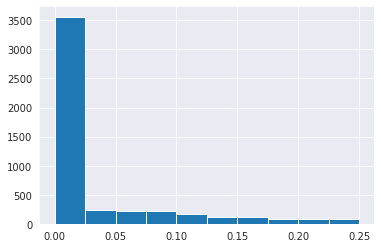

In [56]:
all_vars=[]
for index,row in note_rater_df_copy.iterrows():
    row_filter = row[row.apply(lambda x: True if not np.isnan(x) else False)]
    all_vars.append(np.var(list(row_filter)))


plt.hist(all_vars)

In [57]:
matrix_row = 'noteId'
matric_col = 'participantId'
categorical_column = 'agree'

GetColumnAlpha(ratings_df, categorical_column, matrix_row, matric_col)

85375it [00:22, 3860.11it/s]


0.6036127371635905

## Vanilla Agreement

In [58]:
def find_winner(l):
    a=Counter(l)
    max_value=list(a.values())[0]
    return [x for x in a if a[x]==max_value]

In [59]:
agg_notes_df = notes_df.groupby('tweetId')\
                       .agg({'noteId':'count'})

TweetsWithMoreThanTwoNoters = list(agg_notes_df[agg_notes_df['noteId']>1].index)

print(len(TweetsWithMoreThanTwoNoters)/len(agg_notes_df.index)*100)

t = TweetsWithMoreThanTwoNoters[0]

cat_columns = ['classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources']

for col in cat_columns:
    conflict = 0
    for t in TweetsWithMoreThanTwoNoters:
        values = list(notes_df[notes_df.tweetId==t][col])
        winners = find_winner(values)
        if len(winners)>1: conflict+=1
    print(f'{conflict}/{len(TweetsWithMoreThanTwoNoters)} conflicts for {col}')
        
    

17.100497009518996
387/2030 conflicts for classification
523/2030 conflicts for believable
688/2030 conflicts for harmful
813/2030 conflicts for validationDifficulty
153/2030 conflicts for misleadingOther
599/2030 conflicts for misleadingFactualError
73/2030 conflicts for misleadingManipulatedMedia
207/2030 conflicts for misleadingOutdatedInformation
623/2030 conflicts for misleadingMissingImportantContext
552/2030 conflicts for misleadingUnverifiedClaimAsFact
91/2030 conflicts for misleadingSatire
53/2030 conflicts for notMisleadingOther
251/2030 conflicts for notMisleadingFactuallyCorrect
6/2030 conflicts for notMisleadingOutdatedButNotWhenWritten
51/2030 conflicts for notMisleadingClearlySatire
119/2030 conflicts for notMisleadingPersonalOpinion
502/2030 conflicts for trustworthySources


In [60]:
notes_text_ratings[['tweetId','full_text']].drop_duplicates().to_csv('BW_Tweets.csv',index=False)

In [61]:
agg_rates_df = ratings_df.groupby('noteId')\
                         .agg({'participantId':'count'})

NotesWithMoreThanTwoRaters = list(agg_rates_df[agg_rates_df['participantId']>1].index)

print(len(NotesWithMoreThanTwoRaters)/len(ratings_df)*100)


cat_columns = ['agree',
       'disagree', 'helpfulnessLevel', 'helpfulOther', 'helpfulClear',
       'helpfulGoodSources', 'helpfulAddressesClaim',
       'helpfulImportantContext', 'notHelpfulOther', 'notHelpfulIncorrect',
       'notHelpfulSourcesMissingOrUnreliable', 'notHelpfulMissingKeyPoints',
       'notHelpfulHardToUnderstand', 'notHelpfulArgumentativeOrInflammatory',
       'notHelpfulSpamHarassmentOrAbuse', 'notHelpfulIrrelevantSources']


for col in cat_columns:
    conflict = 0
    for t in NotesWithMoreThanTwoRaters:
        values = list(ratings_df[ratings_df.noteId==t][col])
        winners = find_winner(values)
        if len(winners)>1: conflict+=1
    print(f'{conflict}/{len(NotesWithMoreThanTwoRaters)} conflicts for {col}')
        
    

9.725513655293009
571/8454 conflicts for agree
423/8454 conflicts for disagree
552/8454 conflicts for helpfulnessLevel
77/8454 conflicts for helpfulOther
1144/8454 conflicts for helpfulClear
857/8454 conflicts for helpfulGoodSources
441/8454 conflicts for helpfulAddressesClaim
461/8454 conflicts for helpfulImportantContext
202/8454 conflicts for notHelpfulOther
220/8454 conflicts for notHelpfulIncorrect
422/8454 conflicts for notHelpfulSourcesMissingOrUnreliable
510/8454 conflicts for notHelpfulMissingKeyPoints
102/8454 conflicts for notHelpfulHardToUnderstand
208/8454 conflicts for notHelpfulArgumentativeOrInflammatory
49/8454 conflicts for notHelpfulSpamHarassmentOrAbuse
98/8454 conflicts for notHelpfulIrrelevantSources


## Variance

In [62]:
def ThresholdedConflicts(vars_,thresholds):
    d={}
    for threshold in thresholds:
        c=0
        for v in vars_:
            if v > threshold:
                c+=1
        d[threshold] = c
    return d

3.2890903204920683


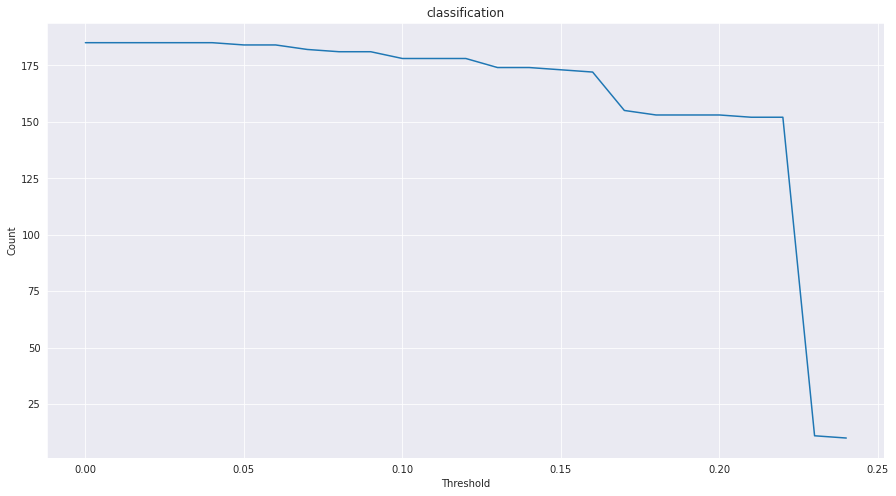

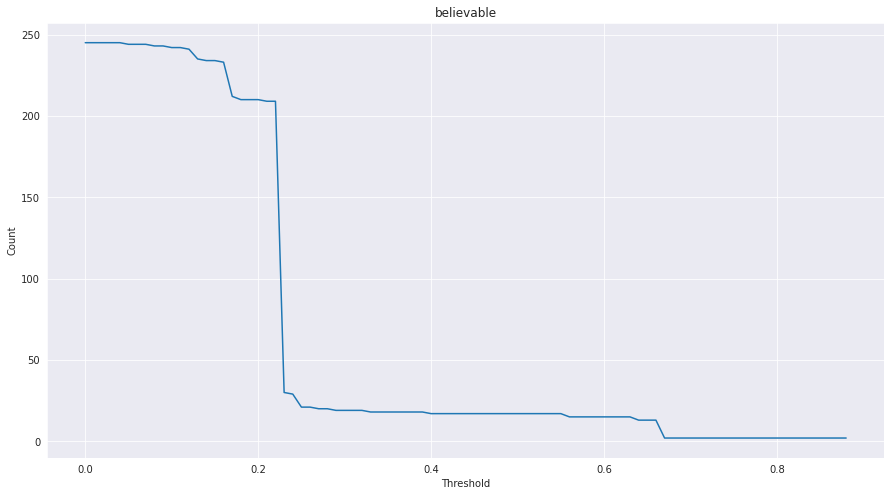

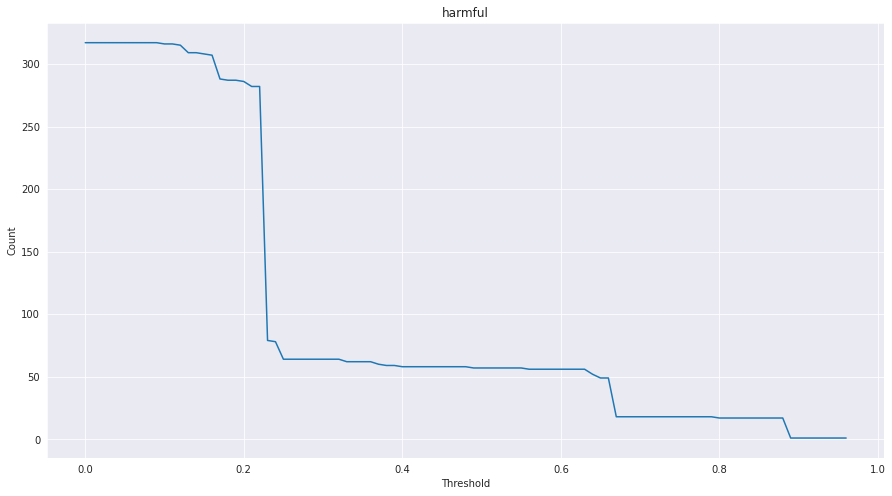

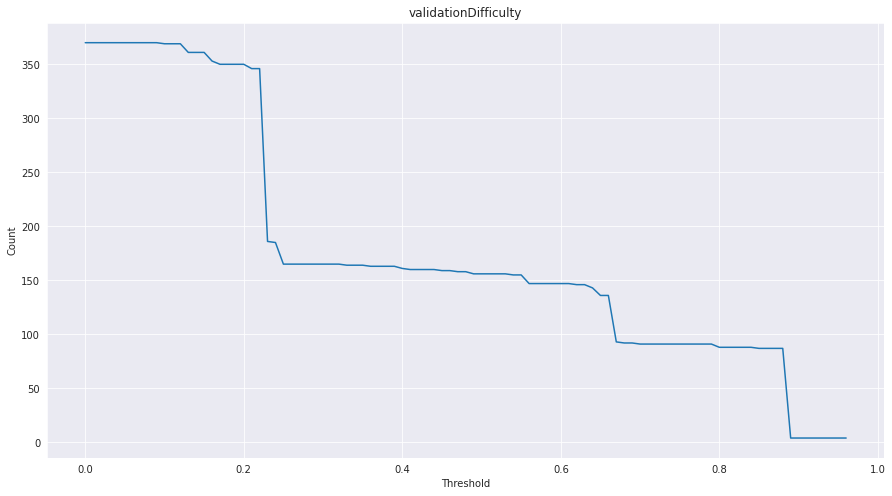

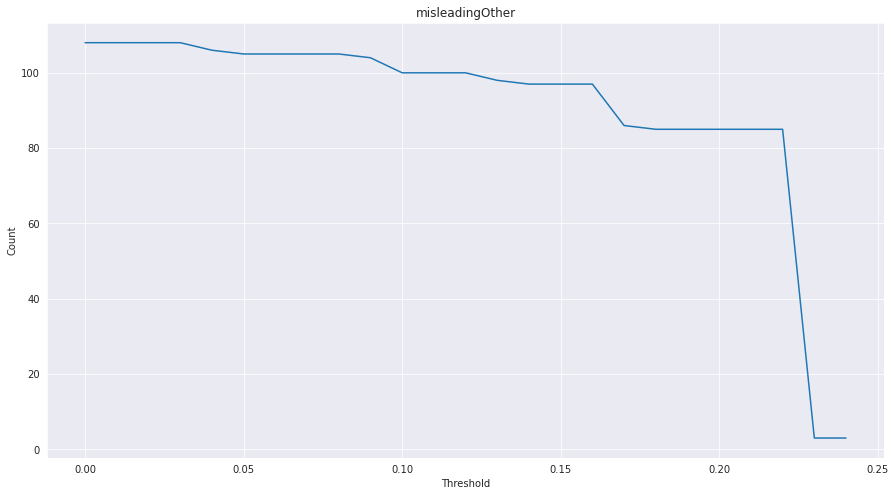

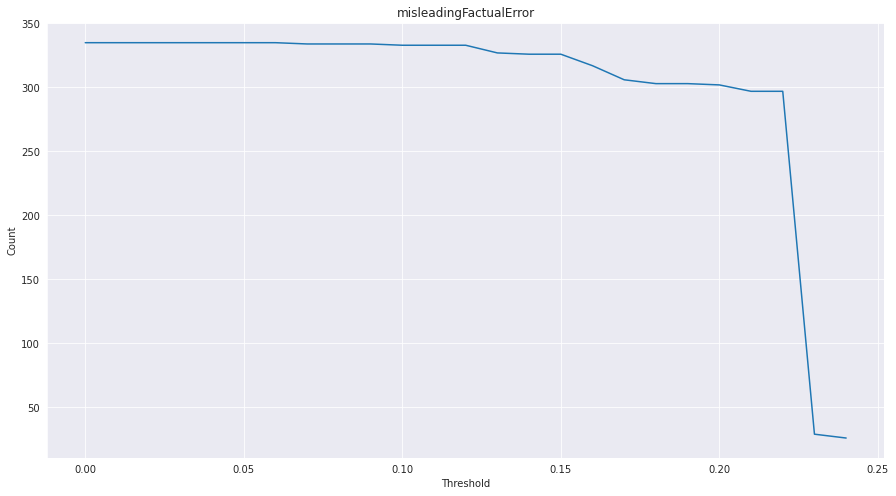

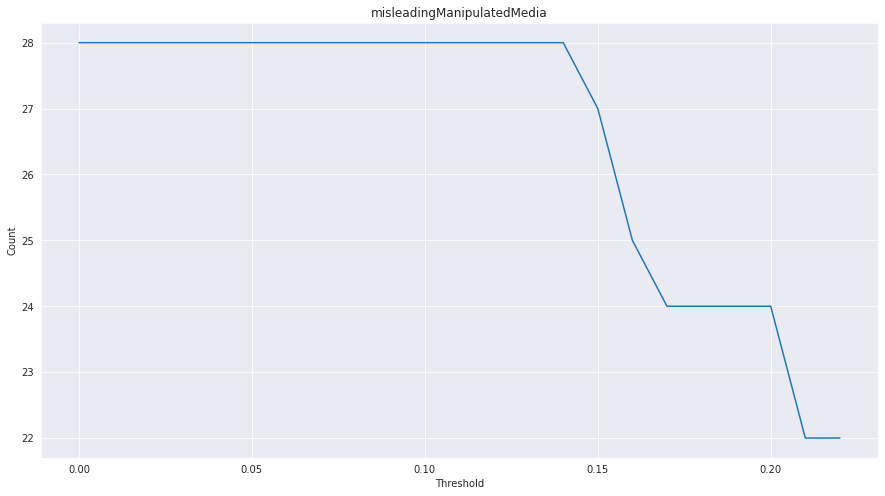

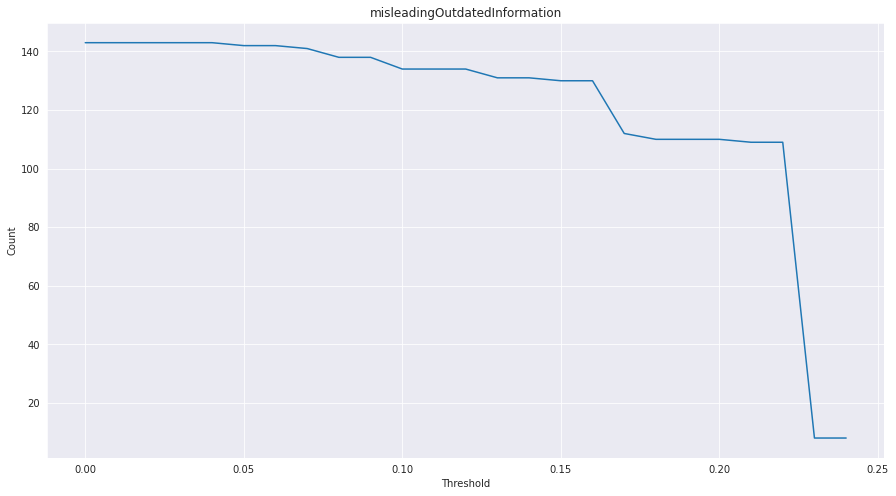

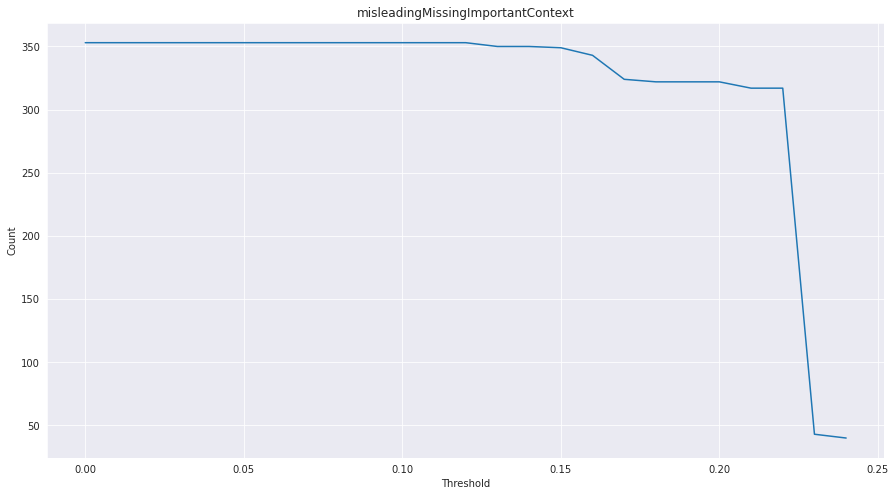

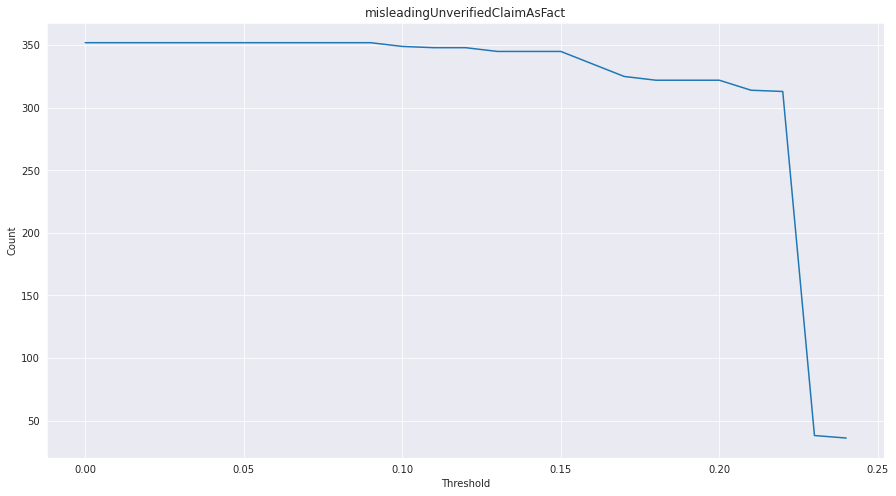

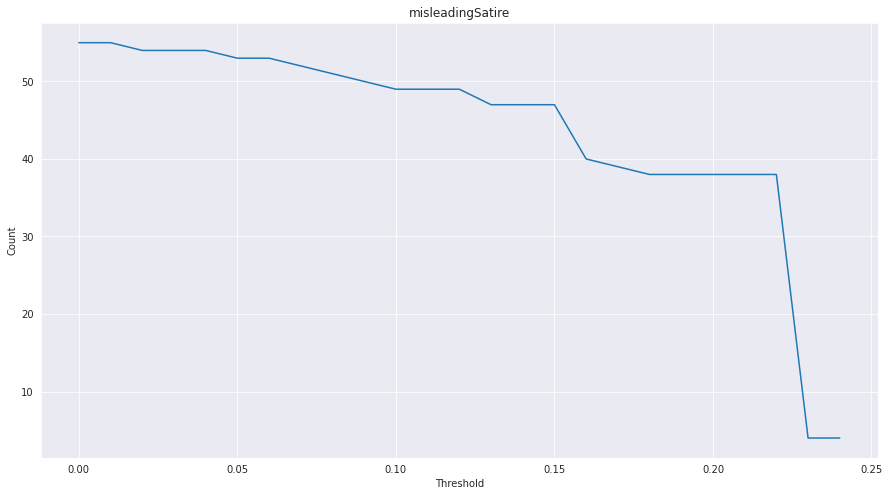

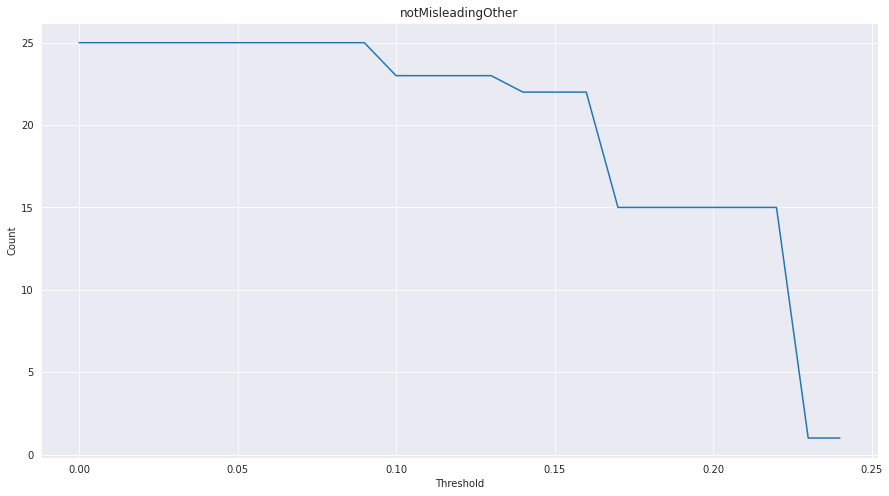

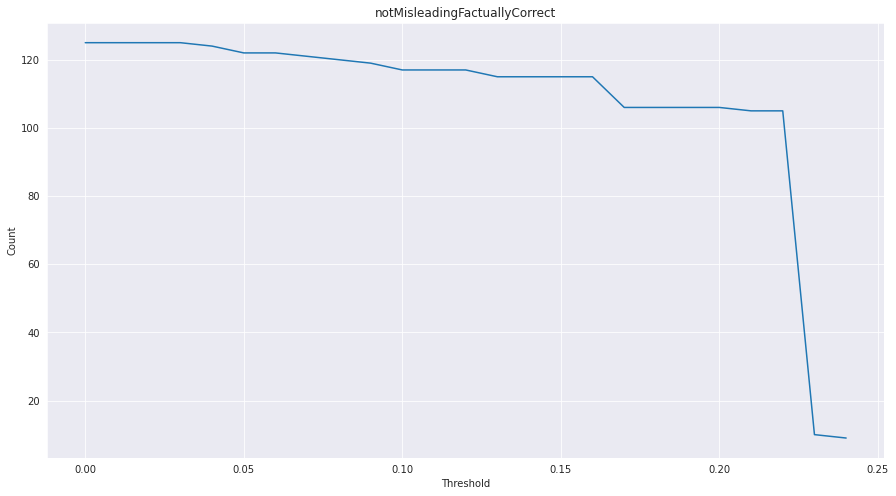

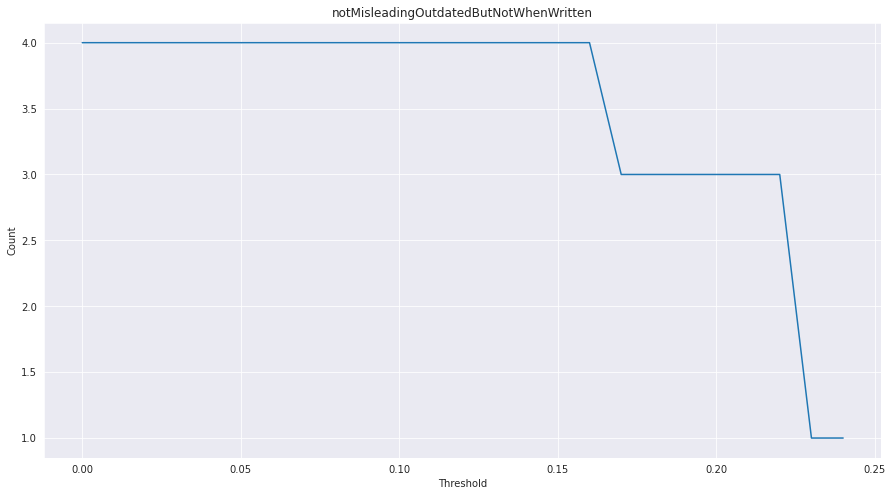

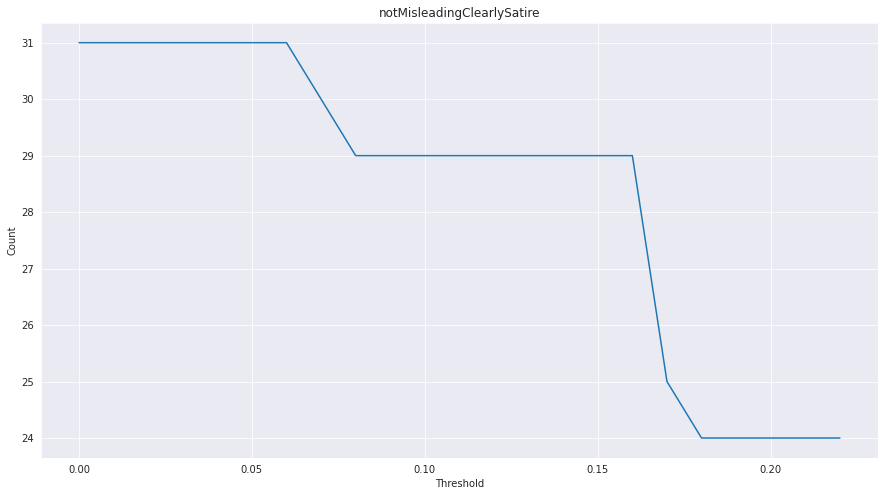

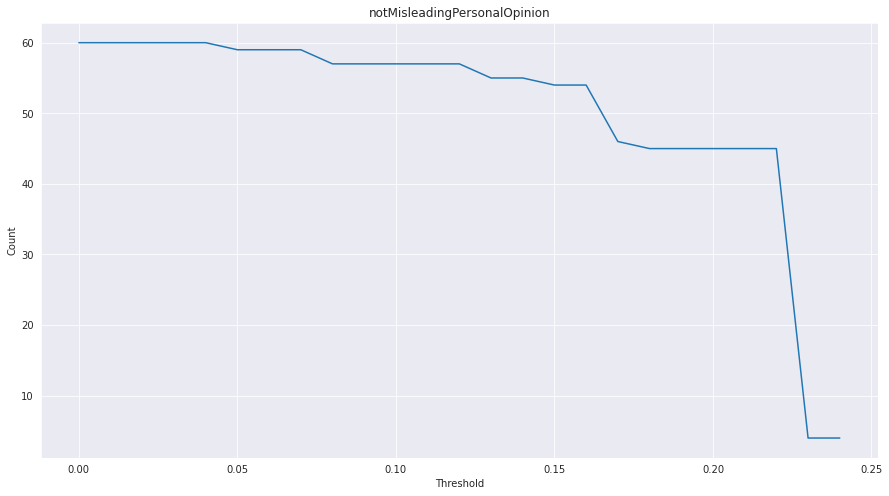

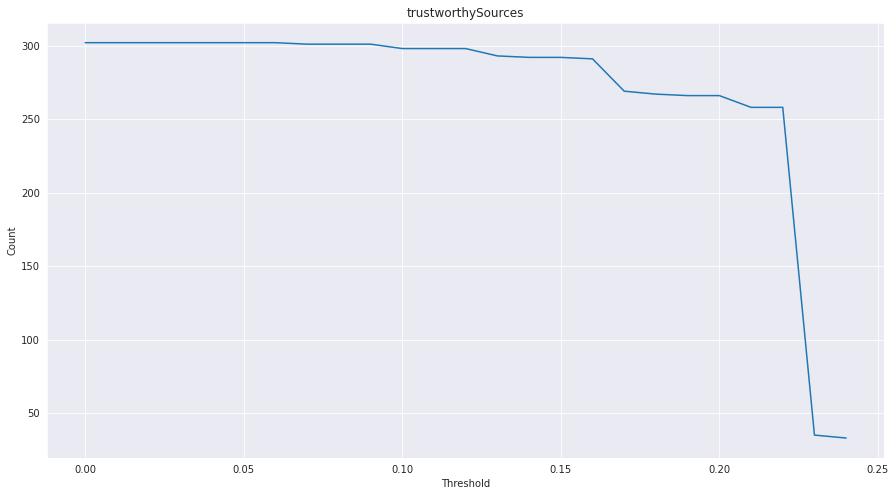

In [63]:
cat_columns = ['classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources']


#odd number of votes > 1
agg_notes_df = notes_df.groupby('tweetId')\
                       .agg({'noteId':'count'})


OddTweets=list(agg_notes_df[(agg_notes_df['noteId']%2) & (agg_notes_df['noteId']>1)].index)

print(len(OddTweets)/len(notes_df)*100)

for categorical_column in cat_columns:
    label2code = dict(zip(notes_df[categorical_column],pd.factorize(notes_df[categorical_column])[0]))

    all_vars=[]
    for t in OddTweets:
        cat_notes=list(notes_df[notes_df.tweetId==t][categorical_column])
        encoded_cat_notes=[label2code[x] for x in cat_notes]
        all_vars.append(np.var(encoded_cat_notes))

    d=ThresholdedConflicts(all_vars,np.arange(0,1.01,0.01))

    lim_index=[i for i,x in enumerate(d) if d[x]==0][0]

    lists = list(d.items())[:lim_index]

    x, y = zip(*lists) 

    plt.figure(figsize=(15,8))
    plt.plot(x, y)
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.title(categorical_column)
    plt.show()

4.3220670455329815


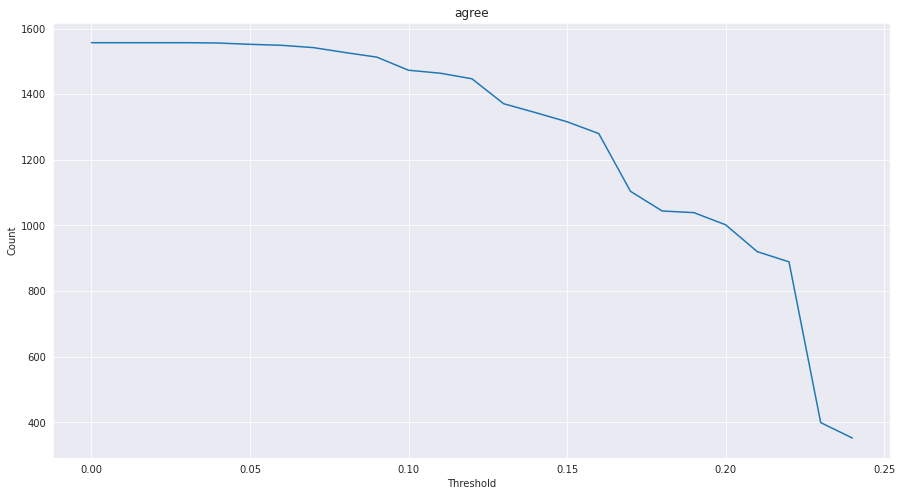

In [64]:
agg_rates_df = ratings_df.groupby('noteId')\
                         .agg({'participantId':'count'})

OddNotes = list(agg_rates_df[(agg_rates_df['participantId']%2) & (agg_rates_df['participantId']>1)].index)

print(len(OddNotes)/len(ratings_df)*100)
a=[]


cat_columns = [ 'agree']


for categorical_column in cat_columns:
    label2code = dict(zip(ratings_df[categorical_column],pd.factorize(ratings_df[categorical_column])[0]))

    all_vars=[]
    for t in OddNotes:
        cat_ratings=list(ratings_df[ratings_df.noteId==t][categorical_column])
        encoded_cat_ratings=[label2code[x] for x in cat_ratings]
        a.append(len(encoded_cat_ratings))
        all_vars.append(np.var(encoded_cat_ratings))

    d=ThresholdedConflicts(all_vars,np.arange(0,2.01,0.01))
    
    lim_index=[i for i,x in enumerate(d) if d[x]==0]
    lim_index = lim_index[0] if lim_index else -1

    lists = list(d.items())[:lim_index] 

    x, y = zip(*lists)

    plt.figure(figsize=(15,8))
    plt.plot(x, y)
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.title(categorical_column)
    plt.show()

(array([2200.,    5.,   22.,   57.,  101.,   56.,  246.,   68.,  596.,
         406.]),
 array([0.        , 0.02499231, 0.04998461, 0.07497692, 0.09996922,
        0.12496153, 0.14995383, 0.17494614, 0.19993844, 0.22493075,
        0.24992305]),
 <BarContainer object of 10 artists>)

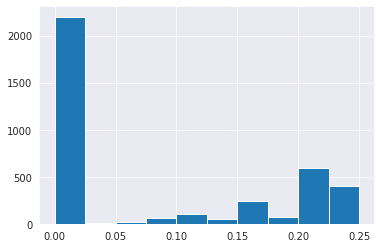

In [65]:
plt.hist(all_vars)